In [8]:
'''
IMPORTS
'''
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob2
import math
# For cordinate isolation
#%matplotlib qt  
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [9]:
def camera_Calibraton(directory, filename, nx, ny, img_size):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []

    # Image List
    images = glob2.glob('./'+directory+'/'+filename+'*'+'.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist


def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

Text(0.5,1,'Undistorted')

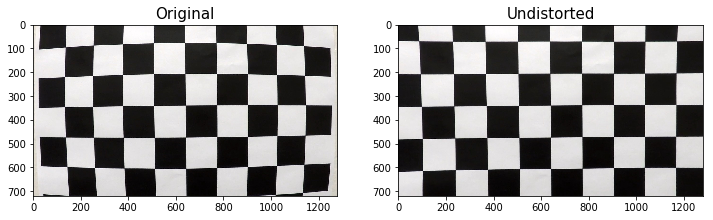

In [10]:
#example of a distortion corrected calibration image

mtx, dist = camera_Calibraton('camera_cal', 'calibration', 9, 6, (720, 1280))
image = mpimg.imread("./camera_cal/calibration1.jpg")
image_undist = undistort(image, mtx, dist)

#PLOT
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(image)
ax1.set_title('Original', fontsize=15)
ax2.imshow(image_undist)
ax2.set_title('Undistorted', fontsize=15)

Text(0.5,1,'Undistorted')

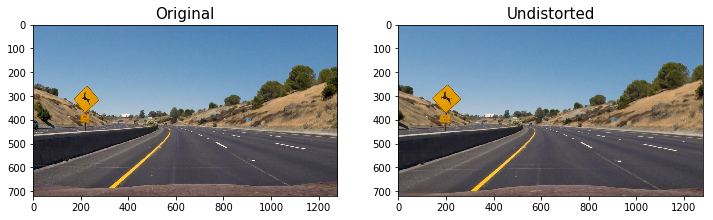

In [11]:
#example of a distortion-corrected image

mtx, dist = camera_Calibraton('camera_cal', 'calibration', 9, 6, (720, 1280))
image = mpimg.imread("./test_images/test2.jpg")
image_undist = undistort(image, mtx, dist)

#PLOT
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(image)
ax1.set_title('Original', fontsize=15)
ax2.imshow(image_undist)
ax2.set_title('Undistorted', fontsize=15)

In [13]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert(orient == 'x' or orient == 'y'), "Orientation must be x or y"
    
    if orient == 'x':
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
 
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelxy = np.power((np.power(sobelx,2)+np.power(sobely,2)),0.5)
    
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

def threshold_Channel(channel,thresh):
    retval, binary = cv2.threshold(channel.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return binary

def channel_Isolate(image,channel):
    ## Takes in only RBG images
    if (channel == 'R'):
        return image[:,:,0]
    
    elif (channel == 'G'):
        return image[:,:,1]
    
    elif (channel == 'B'):
        return image[:,:,2]
    
    elif (channel == 'H'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,0]
    
    elif (channel == 'S'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,1]
        
    elif (channel == 'V'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,2]
        
    elif (channel == 'L'):
        HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        return HLS[:,:,1]
    
    elif (channel == 'Cb'):
        YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        return YCrCb[:,:,2]
    
    elif (channel == 'U'):
        LUV = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        return LUV[:,:,2]
    
    else:
        raise Error("Channel must be either R, G, B, H, S, V, L, Cb, U")
        
        
def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def transform_perspective(undist):
    img_size = undist.shape
    src_1 =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    dst_2 = np.float32([[250,700],[1200,700],[300,50],[1000,50]])
    
    src =  np.float32([[203,720],[1127,720],[585,460],[695,460]])
    dst = np.float32([[320,720],[960,720],[320,0],[960,0]])
    src = np.array([[585, 460], [203, 720], [1127, 720], [695, 460]]).astype(np.float32)
    dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]]).astype(np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]),flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,M,Minv

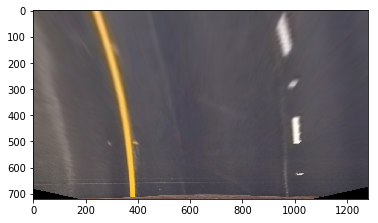

In [14]:
#example of a perspective transformed image

trans_persp,M,Minv=transform_perspective(image_undist)
plt.imshow(trans_persp)

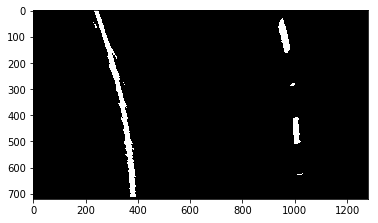

In [15]:
red_threshed = threshold_Channel(channel_Isolate(trans_persp,'R'),(220,255))
V_threshed = threshold_Channel(channel_Isolate(trans_persp,'V'),(220,255))        

HSV = cv2.cvtColor(trans_persp, cv2.COLOR_RGB2HSV)
yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))
plt.imshow(yellow)    
sensitivity_1 = 68
white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

sensitivity_2 = 60
HSL = cv2.cvtColor(trans_persp, cv2.COLOR_RGB2HLS)
white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
       
white_3 = cv2.inRange(trans_persp, (200,200,200), (255,255,255))

bit_layer = red_threshed | V_threshed | yellow | white | white_2 | white_3

plt.imshow(bit_layer,cmap='gray')

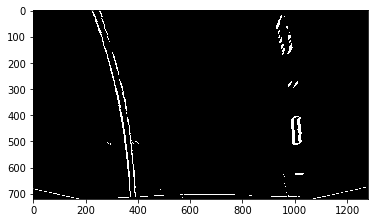

In [16]:
image_HLS = cv2.cvtColor(trans_persp,cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]

sobel_c = sobel_combined(img_gs)

img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

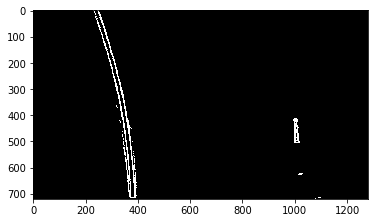

In [17]:
img_gs = image_HLS[:,:,2]

sobel_c = sobel_combined(img_gs)

img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

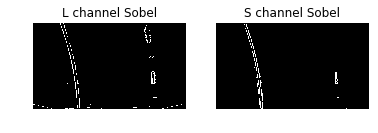

In [18]:
plt.subplot(1,2,1)
plt.imshow(wraped2,cmap='gray')
plt.title('L channel Sobel')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('S channel Sobel')
plt.imshow(wraped3,cmap='gray')
plt.axis('off');

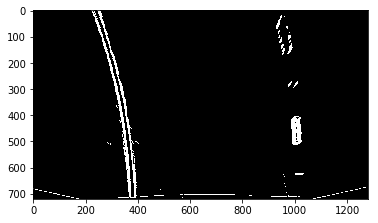

In [19]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
plt.imshow(image_cmb,cmap='gray')

Text(0.5,1,'Color-mask')

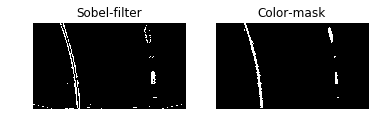

In [20]:
image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(bit_layer>=.5)|(bit_layer>=.5)]=1


plt.subplot(1,2,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,2,2)
plt.imshow(bit_layer,cmap='gray')
plt.axis('off')
plt.title('Color-mask')

(-0.5, 1279.5, 719.5, -0.5)

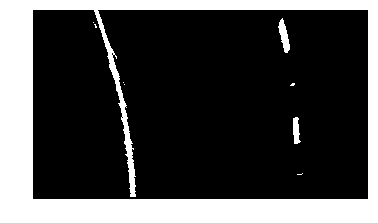

In [21]:
plt.imshow(image_cmb1,cmap='gray')
plt.axis('off')

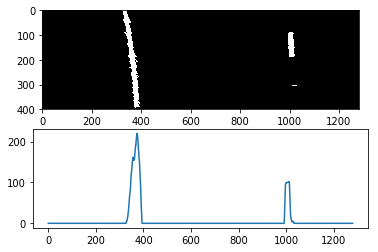

In [24]:
img_size = image_undist.shape
mov_filtsize = img_size[1]/50.
mean_lane = np.sum(image_cmb1[int(image_cmb1.shape[0]/2):,:],axis=0)


plt.plot(mean_lane)
plt.subplot(2,1,1)
plt.imshow(image_cmb1[int(image_cmb1.shape[1]/4):,:],cmap='gray')

plt.subplot(2,1,2)
plt.plot(mean_lane)

In [33]:
def get_initial_mask(img,window_size):
    #img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = img_size[1]/20.
    mean_ln = np.sum(img[int(img_size[0]/2):,:],axis=0)
    
    plt.plot(mean_ln)
    indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L_poly = np.zeros_like(img)
    mask_R_poly = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    diff_R = 0
    diff_L = 0
    for i in range(8):
        

        
        img_y1 = int(img_size[0]-img_size[0]*i/8)
        img_y2 = int(img_size[0]-img_size[0]*(i+1)/8)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,int(mov_filtsize))
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
            if len(indexes)==1:
                if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev+diff_R
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev+diff_R
            else:
                ind_peakL = ind_peakL_prev+diff_R
                ind_peakR = ind_peakR_prev+diff_R
            
                
        if np.abs(ind_peakL-ind_peakL_prev)>=100:
            ind_peakL = ind_peakL_prev
        if np.abs(ind_peakR-ind_peakR_prev)>=100:
            ind_peakR = ind_peakR_prev
    
            
        mask_L_poly[img_y2:img_y1,int(ind_peakL-window_size):int(ind_peakL+window_size)] = 1.     
        mask_R_poly[img_y2:img_y1,int(ind_peakR-window_size):int(ind_peakR+window_size)] = 1.
        
        if i == 0:
            window_size= window_size/1
   
        if i>0:
            diff_R = ind_peakL-ind_peakL_prev
            diff_L = ind_peakR-ind_peakR_prev

    
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
        
        
    return mask_L_poly,mask_R_poly

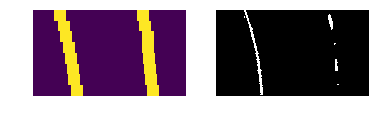

In [34]:
mask_L_poly,mask_R_poly = get_initial_mask(image_cmb1,50)

plt.subplot(1,2,1)
plt.imshow(mask_R_poly+mask_L_poly)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.bitwise_and(image_cmb1,image_cmb1,mask=mask_R_poly+mask_L_poly),cmap='gray')

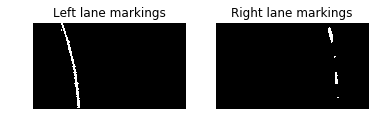

In [35]:
mask_L = mask_L_poly

img_L = np.copy(image_cmb1)
img_L = cv2.bitwise_and(img_L,img_L,mask=mask_L_poly)


mask_R = mask_R_poly

img_R = np.copy(image_cmb1)
img_R = cv2.bitwise_and(img_R,img_R,mask=mask_R_poly)

plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.axis('off')
plt.title('Left lane markings')
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.axis('off')
plt.title('Right lane markings');

In [37]:
vals = np.argwhere(img_L>.5)
all_x = vals.T[0]
all_y =vals.T[1]

left_fit = np.polyfit(all_x, all_y, 2)
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]

vals = np.argwhere(img_R>.5)

all_x = vals.T[0]
all_y =vals.T[1]

right_fit = np.polyfit(all_x, all_y, 2)
right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

window_sz = 20
mask_L_poly = np.zeros_like(image_cmb1)
mask_R_poly = np.zeros_like(image_cmb1)

left_pts = []
right_pts = []

pt_y_all = []

for i in range(8):
    img_y1 = int(img_size[0]-img_size[0]*i/8)
    img_y2 = int(img_size[0]-img_size[0]*(i+1)/8)
    

    pt_y = (img_y1+img_y2)/2
    pt_y_all.append(pt_y)
    left_pt = np.round(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
    right_pt = np.round(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
    
    right_pts.append(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
    left_pts.append(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
    
    mask_L_poly[img_y2:img_y1,int(left_pt-window_sz):int(left_pt+window_sz)] = 1.     
    mask_R_poly[img_y2:img_y1,int(right_pt-window_sz):int(right_pt+window_sz)] = 1.
    
def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)


warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (0,255,255))

col_L = (255,255,255)
col_R = (255,255,255)

draw_pw_lines(color_warp,np.int_(pts_left),col_L)
draw_pw_lines(color_warp,np.int_(pts_right),col_R)


newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 


result = cv2.addWeighted(image_undist, 1, newwarp, 0.5, 0)

(-0.5, 1279.5, 719.5, -0.5)

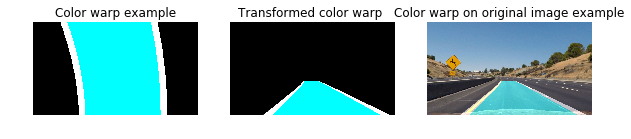

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp example')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp ')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image example')
plt.axis('off')